## Section 4: eQTL Integration

In [1]:
library(tidyverse)
library(data.table)
library(pROC)
library(ssanv)
library(exactci)
library(exact2x2)
library(GGally)
library(ggpubr)
library(patchwork)
library(rmutil)
library(ggrepel)
library(ggridges)
library(epitools)
library(readxl)

setwd("~/work/mpra-v2")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Registered S3 method overwritten by 'rmutil':
  method         from
  print.response httr


Attaching package: ‘rmutil’


The following object is masked from ‘package:tidyr’:

    nesting


The fo

In [2]:
leadVars = fread("annotation/CEU.n69.reMOAT.bestPairs.FDR05.withBeta.txt") %>%
                separate("ENSG",c("geneID","NAME"),sep = "_",extra = "drop") %>% 
                separate("SNP",c("chrom","pos"),sep="_")
leadVars$chrom = sub("^","chr",leadVars$chrom)
leadVars$pos = as.numeric(leadVars$pos)
ilmn2ensg = leadVars[,c(3,6,7)]

ilmn2ensg$NAME[which(ilmn2ensg$NAME == "ILMN")] = ilmn2ensg$geneID[which(ilmn2ensg$NAME == "ILMN")]

In [ ]:
allVars = fread("zcat rawdata/CEU.eQTLAnyPop.n69.reMOAT.CEUsig.txt.gz") %>%
            separate("SNP", c("chrom","pos"), sep="_")

allVars$chrom = sub("^","chr",allVars$chrom)
allVars$pos = as.numeric(allVars$pos)

allVars.ensg = merge(allVars, ilmn2ensg, by.x = "gene", by.y = "ILMN")

In [ ]:
eqtl.gtex = fread("zcat annotation/Cells_EBV-transformed_lymphocytes.allpairs.subset.bed.gz",
                  drop=c(3,7),
                  col.names = c("chrom","pos","ref","alt","geneID","p-value","beta","betaSE"))
eqtl.gtex.ensg = merge(eqtl.gtex, ilmn2ensg, by = "geneID")

In [5]:
hgConvTable = unique(fread("annotation/hgConversionTable.txt", header = T, stringsAsFactors = F))
mpraStats = read.table("sumstats/1KG_novaSeq_DESeq2_Love_Base2.txt", header = T, stringsAsFactors = F)

mpraStats.tmp = mpraStats[,c(3,4,5,6,7,8,9,23,27,29,33)]
mpraStats.tmp = subset(mpraStats.tmp, haploFlag == "Base")
mpraStats.tmp = merge(mpraStats.tmp, unique(hgConvTable),by.x = c("chrom","pos"), by.y = c("hg19_chrom","hg19_pos"))

mpraStats.eqtl= merge(mpraStats.tmp, allVars.ensg, by = c("chrom","pos","geneID"))
mpraStats.eqtl.sep = separate_rows(mpraStats.eqtl, geneID, sep = ",")

mpraStats.eqtl.sep = merge(mpraStats.eqtl.sep,
                           eqtl.gtex.ensg,
                           by.x = c("hg38_chrom","hg38_pos","ref","alt","geneID","NAME"),
                           by.y = c("chrom","pos","ref","alt","geneID","NAME"))

In [6]:
eQTLcompare = merge(mpraStats.tmp, allVars.ensg,
                    by = c("chrom","pos","geneID"))
eQTLcompare = merge(eQTLcompare, eqtl.gtex.ensg,
                    by.x= c("hg38_chrom","hg38_pos","geneID","ref","alt"),
                    by.y = c("chrom","pos","geneID","ref","alt"))

Warning message:
“Removed 1 rows containing missing values (geom_point).”


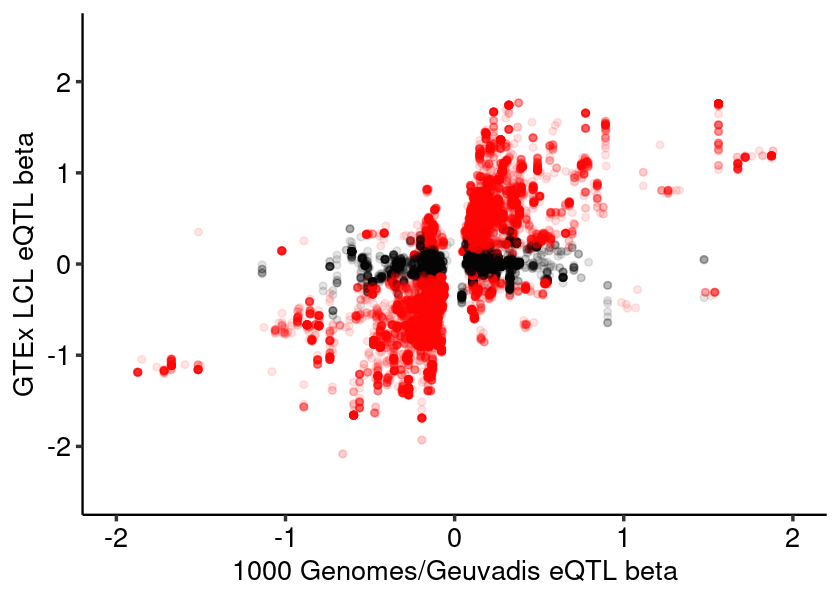

In [7]:
options(repr.plot.width = 7, repr.plot.height = 5)
ggplot(eQTLcompare) +
    geom_point(aes(x = beta.x,
                   y = beta.y,
                   color = ifelse(`p-value.x` < 5e-2 & `p-value.y` < 5e-2,"red","black")),
               alpha = 0.1) +
    scale_color_identity() +
    theme_pubr(base_size = 16) +
    xlab("1000 Genomes/Geuvadis eQTL beta") + ylab("GTEx LCL eQTL beta") +
    xlim(c(-2,2)) + ylim(c(-2.5,2.5))

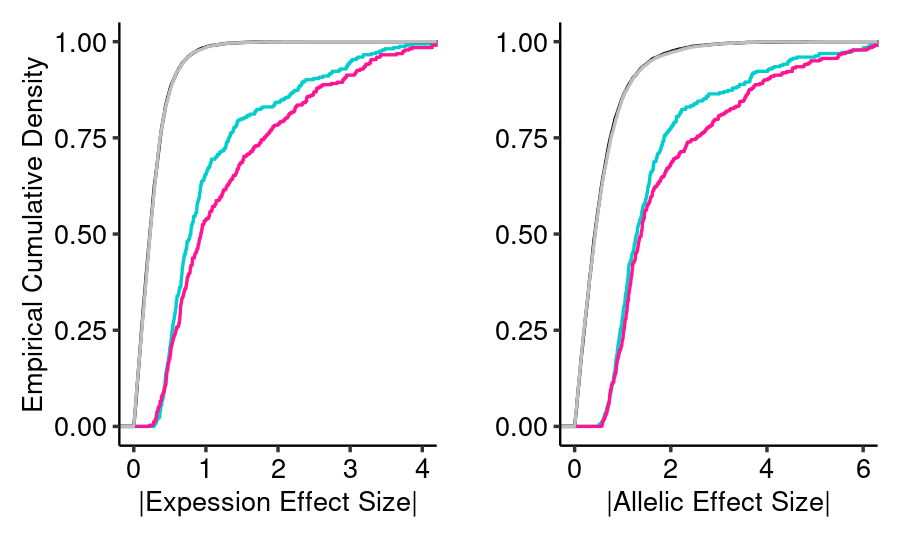

In [6]:
mpraStats.eqtl.sep$hit = NA
mpraStats.eqtl.sep$hit[which(mpraStats.eqtl.sep$padj_allele < 5e-2 & 
                             mpraStats.eqtl.sep$padj_expr < 5e-2 & 
                             mpraStats.eqtl.sep$`p-value.x` < 5e-2 & mpraStats.eqtl.sep$`p-value.y` < 5e-2 &
                             sign(mpraStats.eqtl.sep$beta.x) == sign(mpraStats.eqtl.sep$beta.y))] = "hit"
mpraStats.eqtl.sep$hit[which(mpraStats.eqtl.sep$padj_allele > 5e-2 & 
                             mpraStats.eqtl.sep$padj_expr > 5e-2 )] = "nonhit"

mpraStats.eqtl.sep$exprHit = ifelse(mpraStats.eqtl.sep$padj_expr < 5e-2,"hit","nonhit")

options(repr.plot.width=7.5,repr.plot.height = 4.5)
p1 = ggplot() + 
    stat_ecdf(data = subset(mpraStats.eqtl.sep, !is.na(hit)),
              aes(color = interaction(sign(log2FoldChange_allele) == sign(beta.x), hit),
                  x = abs(log2FoldChange_expr)),
              size = 0.7)  +
    theme_pubr(base_size = 16) + coord_cartesian(xlim = c(0,4)) +
    xlab("|Expession Effect Size|") + ylab("Empirical Cumulative Density")
p2 = ggplot() + 
    stat_ecdf(data = subset(mpraStats.eqtl.sep, !is.na(hit)),
              aes(color = interaction(sign(log2FoldChange_allele) == sign(beta.x), hit),
                  x = abs(log2FoldChange_allele)),
              size = 0.7)  +
    theme_pubr(base_size = 16) + coord_cartesian(xlim = c(0,6)) +
    xlab("|Allelic Effect Size|")+ ylab("")

p1 + p2 & 
    theme(legend.position = "none") &
    scale_color_manual(values = c("FALSE.hit" = "cyan3","TRUE.hit" = "deeppink",
                                  "FALSE.nonhit" = "black", "TRUE.nonhit" = "gray"))

In [19]:
p = subset(mpraStats.eqtl.sep, padj_expr<5e-2)
p %>% group_by(geneID) %>% summarize(n=n()) %>% dim()
p %>% group_by(geneID) %>% summarize(n=n()) %>% filter(n == 1) %>% dim()
p %>% group_by(geneID) %>% summarize(n=n()) %>% filter(n > 1) %>% dim()

p = subset(mpraStats.eqtl.sep, padj_expr<5e-2 & padj_allele < 5e-2)
p %>% group_by(geneID) %>% summarize(n=n()) %>% dim()
p %>% group_by(geneID) %>% summarize(n=n()) %>% filter(n == 1) %>% dim()
p %>% group_by(geneID) %>% summarize(n=n()) %>% filter(n > 1) %>% dim()

p = subset(mpraStats.eqtl.sep, padj_expr<5e-2 & padj_allele < 5e-2 & abs(log2FoldChange_expr) > 1.4)
p %>% group_by(geneID) %>% summarize(n=n()) %>% filter(n > 1) %>% dim()

`summarise()` ungrouping output (override with `.groups` argument)



[1] 571   2

`summarise()` ungrouping output (override with `.groups` argument)



[1] 82  2

`summarise()` ungrouping output (override with `.groups` argument)



[1] 489   2

`summarise()` ungrouping output (override with `.groups` argument)



[1] 339   2

`summarise()` ungrouping output (override with `.groups` argument)



[1] 144   2

`summarise()` ungrouping output (override with `.groups` argument)



[1] 195   2

`summarise()` ungrouping output (override with `.groups` argument)



[1] 47  2

## ALLELIC EFFECT DISTRIBUTION ACROSS LOCI

In [9]:
pA = mpraStats.eqtl.sep %>% 
                filter(geneID != "NA") %>%
                group_by(geneID,exprHit) %>%
                summarize("count" = n()) %>%
                filter(exprHit ==  "hit")  %>% ggplot(aes(y=count)) + 
                                                    geom_histogram(binwidth=5, color = "white",fill= "black")+  
                                                    theme_pubr(base_size = 20)+ 
                                                    scale_y_continuous(trans="reverse",breaks = c(1,25,50,75,100)) + 
                                                    xlab("") + ylab("Number of MPRA\nExpression Effects in Locus")

pB = mpraStats.eqtl.sep %>% 
                filter(geneID != "NA") %>%
                group_by(geneID,hit) %>%
                summarize("count" = n())%>%
                filter(hit ==  "hit") %>% ggplot(aes(y=count)) + 
                                                        geom_histogram(binwidth=1,color = "white",fill = "black")+  
                                                        theme_pubr(base_size = 20)+ 
                                                        scale_y_continuous(trans="reverse",breaks = c(1,5,10,15))+ 
                                                        xlab("Number of Loci") + ylab("Number of MPRA\nAllelic Effects in Locus")

`summarise()` regrouping output by 'geneID' (override with `.groups` argument)

`summarise()` regrouping output by 'geneID' (override with `.groups` argument)



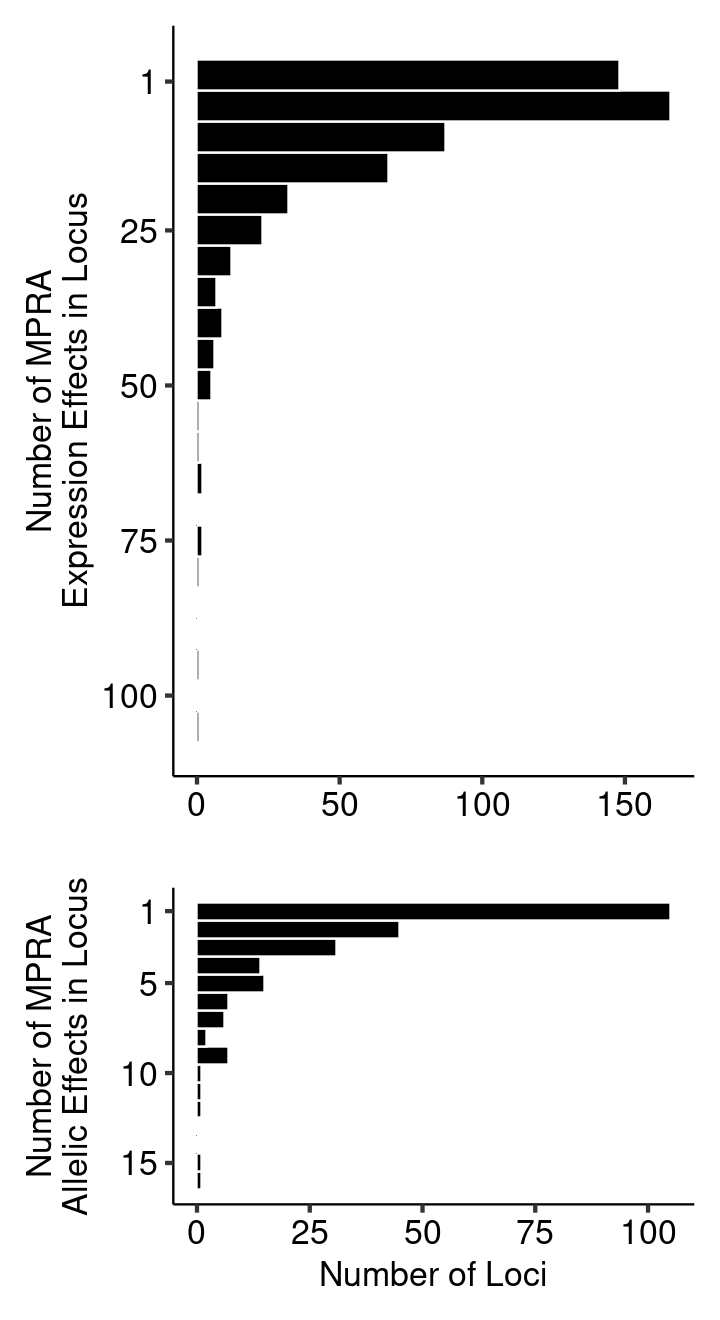

In [10]:
options(repr.plot.width=6, repr.plot.height = 11)
pA / pB & theme(axis.title.y = element_text(angle = 90)) & plot_layout(design = "A\nA\nA\nA\nA\nA\nA\nB\nB\nB\n")

## CONCORDANCE STRATIFIED BY MPRA EFFECT AND ENCODE OVERLAP

In [33]:
effectSizeCutoff = 1.4

mpraStats.eqtl.sep$hit = NA
mpraStats.eqtl.sep$hit[which(mpraStats.eqtl.sep$padj_allele < 5e-2 & 
                             mpraStats.eqtl.sep$padj_expr < 5e-2 & 
                             sign(mpraStats.eqtl.sep$beta.x) == sign(mpraStats.eqtl.sep$beta.y) &
                             mpraStats.eqtl.sep$`p-value.x` < 5e-2 & mpraStats.eqtl.sep$`p-value.y` < 5e-2 &
                             abs(mpraStats.eqtl.sep$log2FoldChange_expr) > effectSizeCutoff)] = "hit"
mpraStats.eqtl.sep$hit[which(mpraStats.eqtl.sep$padj_allele > 5e-2 & 
                             mpraStats.eqtl.sep$padj_expr > 5e-2 )] = "nonhit"

mpraStats.eqtl.sep$exprHit = ifelse(mpraStats.eqtl.sep$padj_expr < 5e-2 & 
                                    abs(mpraStats.eqtl.sep$log2FoldChange_expr) > log2(effectSizeCutoff),"hit","nonhit")

geneCount = mpraStats.eqtl.sep %>% 
                filter(geneID != "NA") %>%
                group_by(geneID,hit) %>%
                summarize("count" = n())

tmp = subset(mpraStats.eqtl.sep,!is.na(hit))
table(sign(tmp$beta.y) == sign(tmp$log2FoldChange_allele), tmp$hit)
fisher.test(table(tmp$hit, sign(tmp$beta.y) == sign(tmp$log2FoldChange_allele)))

`summarise()` regrouping output by 'geneID' (override with `.groups` argument)



       
         hit nonhit
  FALSE   72   8112
  TRUE   112   8021


	Fisher's Exact Test for Count Data

data:  table(tmp$hit, sign(tmp$beta.y) == sign(tmp$log2FoldChange_allele))
p-value = 0.002935
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.4652721 0.8638059
sample estimates:
odds ratio 
  0.635667 


In [34]:
subset(mpraStats, padj_expr < 5e-2 & padj_allele < 5e-2 & geneID == "ENSG00000100266",
       select = c("VarID","log2FoldChange_expr","log2FoldChange_allele"))

,VarID,log2FoldChange_expr,log2FoldChange_allele
,<chr>,<dbl>,<dbl>
22174,var30635,-0.5906837,1.0992891
22202,var30660,2.7767494,4.8698454
22206,var30665,0.4652891,-1.0993860
22252,var30712,1.6639081,1.6145622
22309,var30772,-1.8478940,3.7387050
22354,var30816,-0.4818277,-0.9477392
22367,var30828,-1.0184720,-1.5450268
22388,var30848,-0.5236207,0.7360484
22391,var30850,1.9132491,1.4326293


Picking joint bandwidth of 0.0667

Warning message:
“Removed 322 rows containing non-finite values (stat_density_ridges).”
Picking joint bandwidth of 0.183



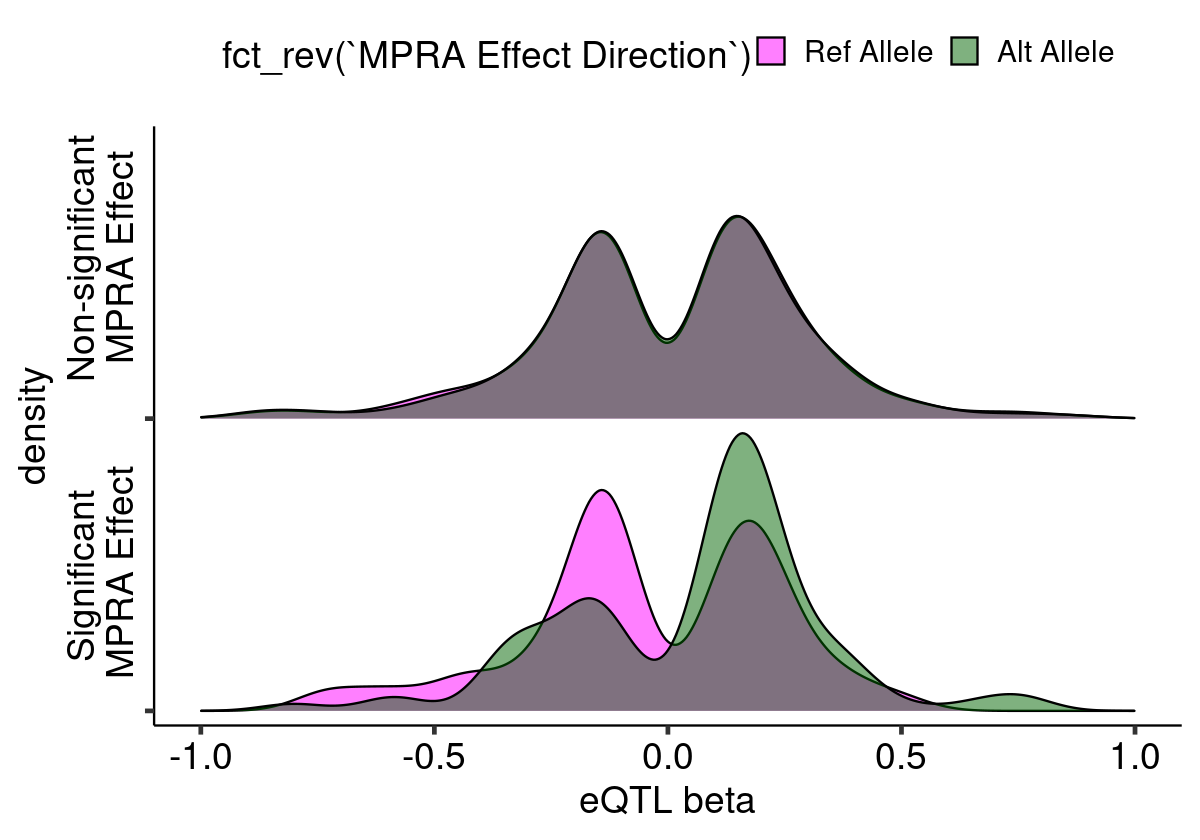

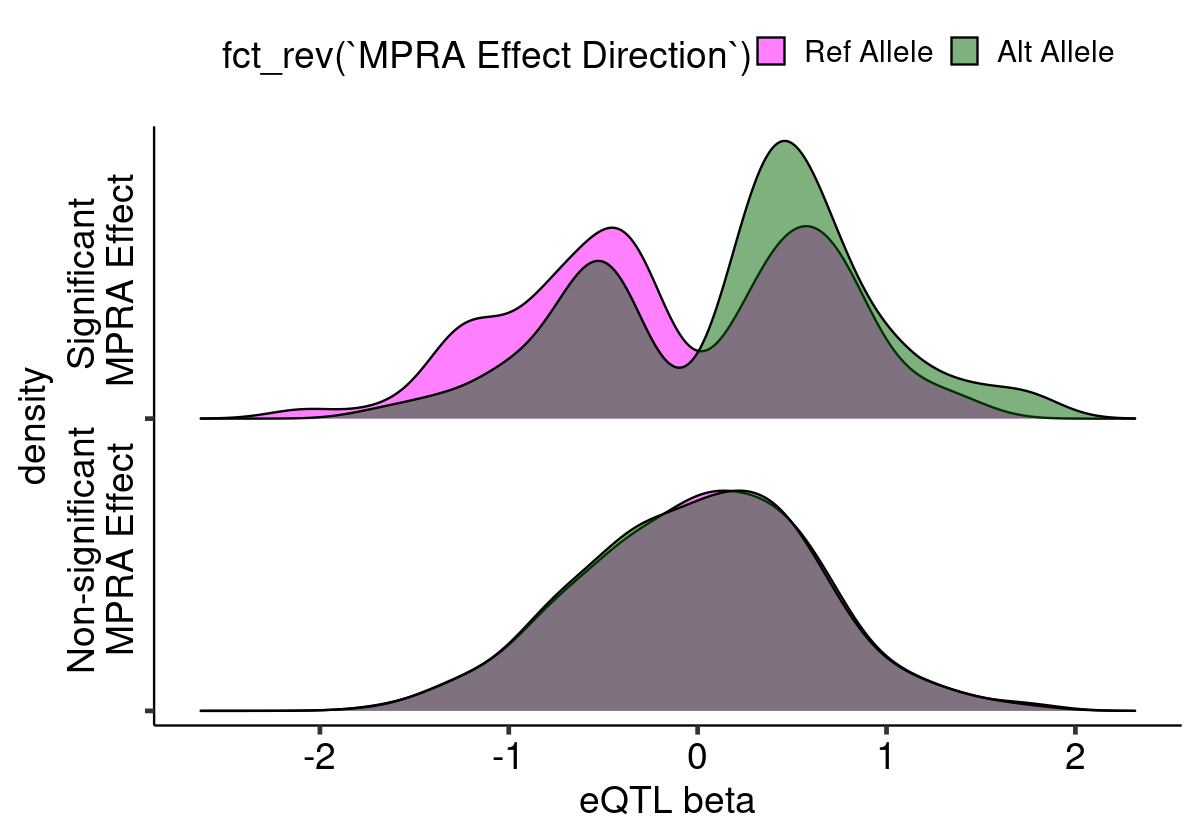

In [35]:
pC = subset(mpraStats.eqtl.sep,!is.na(hit)) %>% 
    mutate("MPRA Effect Direction" = ifelse(log2FoldChange_allele  > 0,"Alt Allele","Ref Allele")) %>%
    mutate(hit = ifelse(hit  == "hit","  Significant\nMPRA Effect","Non-significant\n  MPRA Effect")) %>%
        ggplot(aes(x = beta.x, fill = fct_rev(`MPRA Effect Direction`), y = reorder(hit,beta.x))) +
            geom_density_ridges(alpha=0.5, 
                                scale = 0.95) + 
            xlim(c(-1,1)) + 
            scale_y_discrete(expand = expansion(add = c(0.05, 1))) +
            theme_pubr(base_size = 22) + ylab("density") + xlab("eQTL beta") +
            scale_fill_manual(values = c("magenta" , "darkgreen"))  +
            theme(axis.text.y = element_text(hjust=-0.15,angle=90))

pC.gtex = subset(mpraStats.eqtl.sep,!is.na(hit)) %>% 
    mutate("MPRA Effect Direction" = ifelse(log2FoldChange_allele  > 0,"Alt Allele","Ref Allele")) %>%
    mutate(hit = ifelse(hit  == "hit","  Significant\nMPRA Effect","Non-significant\n  MPRA Effect")) %>%
        ggplot(aes(x = beta.y, fill = fct_rev(`MPRA Effect Direction`), y = reorder(hit,beta.y))) +
            geom_density_ridges(alpha=0.5, 
                                scale = 0.95) + 
            #xlim(c(-1,1)) + 
            scale_y_discrete(expand = expansion(add = c(0.05, 1))) +
            theme_pubr(base_size = 22) + ylab("density") + xlab("eQTL beta") +
            scale_fill_manual(values = c("magenta" , "darkgreen"))  +
            theme(axis.text.y = element_text(hjust=-0.15,angle=90))

options(repr.plot.width=10,repr.plot.height = 7)
pC
pC.gtex

In [36]:
p  = subset(mpraStats.eqtl.sep,hit == "hit")
fisher.test(p$log2FoldChange_allele > 0, p$beta.y > 0)

p  = subset(mpraStats.eqtl.sep,hit == "nonhit")
fisher.test(p$log2FoldChange_allele > 0, p$beta.y > 0)


	Fisher's Exact Test for Count Data

data:  p$log2FoldChange_allele > 0 and p$beta.y > 0
p-value = 0.004746
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.261532 4.525948
sample estimates:
odds ratio 
  2.375313 



	Fisher's Exact Test for Count Data

data:  p$log2FoldChange_allele > 0 and p$beta.y > 0
p-value = 0.4781
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.9184636 1.0402837
sample estimates:
odds ratio 
 0.9774843 


In [37]:
p  = subset(mpraStats.eqtl.sep,hit == "hit")
fisher.test(p$log2FoldChange_allele > 0, p$beta.x > 0)

p  = subset(mpraStats.eqtl.sep,hit == "nonhit")
fisher.test(p$log2FoldChange_allele > 0, p$beta.x > 0)


	Fisher's Exact Test for Count Data

data:  p$log2FoldChange_allele > 0 and p$beta.x > 0
p-value = 0.004746
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.261532 4.525948
sample estimates:
odds ratio 
  2.375313 



	Fisher's Exact Test for Count Data

data:  p$log2FoldChange_allele > 0 and p$beta.x > 0
p-value = 0.9121
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.9429131 1.0680824
sample estimates:
odds ratio 
  1.003544 


## HAPLOYTPE COMPARISONS

In [38]:
mpraStats.eqtl.sep$concord = ifelse(sign(mpraStats.eqtl.sep$log2FoldChange_allele) == 
                                    sign(mpraStats.eqtl.sep$beta.y),"concordant","discordant")

probSum.hits = mpraStats.eqtl.sep %>% 
                    filter(geneID != "NA" & !is.na(hit)) %>% 
                    group_by(geneID, hit, concord) %>% 
                    summarize(count = n()) %>% 
                    spread(concord, count, fill = 0) %>%
                    filter(hit == "hit") %>% 
                    summarize(propConcord = concordant/(concordant + discordant),
                              numVars = concordant + discordant) %>%
                    group_by(propConcord, numVars) %>% 
                    select(-geneID, -hit) %>% 
                    summarize(numGenes = n())

probSum.nonhits = mpraStats.eqtl.sep %>% 
                    filter(geneID != "NA" & !is.na(hit)) %>% 
                    group_by(geneID, hit, concord) %>% 
                    summarize(count = n()) %>% 
                    spread(concord, count, fill = 0) %>%
                    filter(hit == "nonhit") %>% 
                    summarize(propConcord = concordant/(concordant + discordant),
                              numVars = concordant + discordant) %>%
                    group_by(propConcord, numVars) %>% 
                    select(-geneID, -hit) %>% 
                    summarize(numGenes = n())

probSum.hit.dist = probSum.hits %>% group_by(propConcord) %>% summarize(numGenes = sum(numGenes))
probSum.nonhit.dist = probSum.nonhits %>% group_by(propConcord) %>% summarize(numGenes = sum(numGenes))

probSum.hit.dist$group = "observed"
probSum.hit.dist$hit = "hit"

probSum.nonhit.dist$group = "observed"
probSum.nonhit.dist$hit = "nonhit"

`summarise()` regrouping output by 'geneID', 'hit' (override with `.groups` argument)

`summarise()` regrouping output by 'geneID' (override with `.groups` argument)

`summarise()` regrouping output by 'propConcord' (override with `.groups` argument)

`summarise()` regrouping output by 'geneID', 'hit' (override with `.groups` argument)

`summarise()` regrouping output by 'geneID' (override with `.groups` argument)

`summarise()` regrouping output by 'propConcord' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [39]:
probSum.hits.nullTable = probSum.hits %>% group_by(numVars) %>% summarize(numGenes = sum(numGenes))
probSum.hits.null = data.frame("propConcord" = numeric(), "numGenes" = numeric())

for(i in 1:nrow(probSum.hits.nullTable)){
    
    num = as.numeric(probSum.hits.nullTable[i,1])
    tmp = data.frame("propConcord" = seq(0,num)/num, "numGenes" = dbinom(seq(0,num),num,0.5)*as.numeric(probSum.hits.nullTable[i,2]))
    probSum.hits.null = rbind(probSum.hits.null, tmp)
    
}

probSum.hits.null = probSum.hits.null %>% group_by(propConcord) %>% summarize(numGenes = sum(numGenes))

probSum.hits.null$group = "expected"
probSum.hits.null$hit = "hit"

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [40]:
probSum.nonhits.nullTable = probSum.nonhits %>% group_by(numVars) %>% summarize(numGenes = sum(numGenes))
probSum.nonhits.null = data.frame("propConcord" = numeric(), "numGenes" = numeric())

for(i in 1:nrow(probSum.nonhits.nullTable)){
    
    num = as.numeric(probSum.nonhits.nullTable[i,1])
    tmp = data.frame("propConcord" = seq(0,num)/num, "numGenes" = dbinom(seq(0,num),num,0.5)*as.numeric(probSum.nonhits.nullTable[i,2]))
    probSum.nonhits.null = rbind(probSum.nonhits.null, tmp)
    
}

probSum.nonhits.null = probSum.nonhits.null %>% group_by(propConcord) %>% summarize(numGenes = sum(numGenes))

probSum.nonhits.null$group = "expected"
probSum.nonhits.null$hit = "nonhit"

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [41]:
testCounts = mpraStats.eqtl.sep %>% 
                    filter(geneID != "NA" & !is.na(hit)) %>% 
                    group_by(geneID, hit, concord) %>% 
                    summarize(count = n()) %>% 
                    spread(concord, count, fill = 0)

propConcordTable = rbind(rbind(probSum.hit.dist, probSum.hits.null), rbind(probSum.nonhit.dist, probSum.nonhits.null))

binModel = glm(cbind(concordant,discordant)~factor(hit,levels=c("nonhit","hit")),
                data=testCounts,
                family="binomial")
summary(binModel)

`summarise()` regrouping output by 'geneID', 'hit' (override with `.groups` argument)




Call:
glm(formula = cbind(concordant, discordant) ~ factor(hit, levels = c("nonhit", 
    "hit")), family = "binomial", data = testCounts)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.6828  -0.8982   0.0211   0.9964   2.7298  

Coefficients:
                                            Estimate Std. Error z value
(Intercept)                                 -0.01128    0.01575  -0.716
factor(hit, levels = c("nonhit", "hit"))hit  0.45311    0.15187   2.984
                                            Pr(>|z|)   
(Intercept)                                  0.47372   
factor(hit, levels = c("nonhit", "hit"))hit  0.00285 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 877.94  on 738  degrees of freedom
Residual deviance: 868.82  on 737  degrees of freedom
AIC: 2640.1

Number of Fisher Scoring iterations: 3


In [42]:
pD = ggplot(propConcordTable) +
            geom_density(aes(x = propConcord, 
                             weight = numGenes, 
                             color = hit,
                             linetype = group,
                             lty = ifelse(group == "observed",0,14)),size = 1, bw=0.05) + 
                theme_pubr(base_size = 20) +
                scale_color_manual(values = c("hit" = "red", "nonhit" = "black")) +
                theme(legend.title = element_blank(),legend.position = "none") + 
                xlab("Concordance Proportion Across Loci") +
                scale_linetype_manual(values = c("observed" = "solid", "expected" =  "4F")) 

Warning message:
“Duplicated aesthetics after name standardisation: linetype”


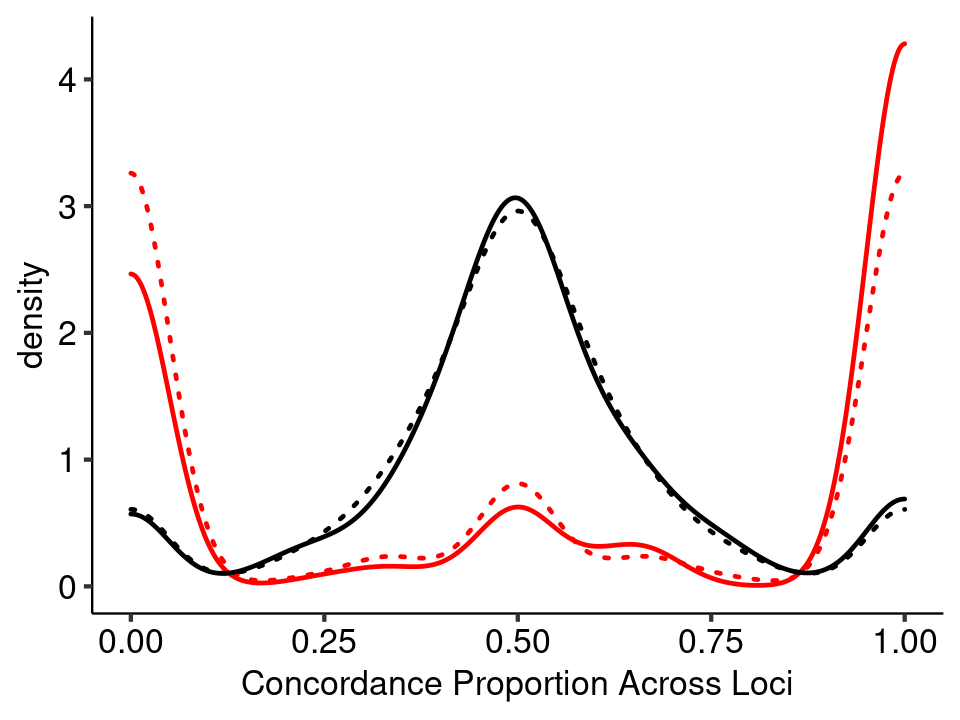

In [43]:
options(repr.plot.width=8,repr.plot.height = 6)
pD

In [44]:
multiHitGenes = unlist(mpraStats.eqtl.sep %>% 
                    filter(geneID != "NA" & hit == "hit") %>% 
                    group_by(geneID) %>% 
                    filter(n() >= 1) %>% select(geneID))
multiHits = subset(mpraStats.eqtl.sep,
            geneID != "NA" & hit == "hit" & geneID %in% multiHitGenes,
            select = c("NAME","beta.x","log2FoldChange_allele"))
multiHits$NAME[which(multiHits$NAME == "ENSG00000164308")] = "ERAP2"
multiHits$NAME[which(multiHits$NAME == "ENSG00000145348")] = "TBCK"
multiHits$NAME[which(multiHits$NAME == "ENSG00000203965")] = "EFCAB7"
multiHits$NAME[which(multiHits$NAME == "C1orf156")] = "METTL18"
multiHits$NAME[which(multiHits$NAME == "ENSG00000171103")] = "TRMT61B"

In [45]:
singHitPlot = multiHits %>% 
                mutate("concord" = ifelse(sign(beta.x) == sign(log2FoldChange_allele), "concord","discord")) %>%
                group_by(NAME,concord) %>% 
                summarize(count = n()) %>% 
                spread(concord, count, fill=0) %>% filter(concord+discord >= 2)

pE1 = ggplot(singHitPlot, aes( group = 1, y = reorder(NAME,concord*1.1+discord), yend = reorder(NAME,concord*1.1+discord))) +
    geom_segment(aes(x = 0, xend = concord), color = "deeppink", size = 5) +
    geom_segment(aes(x = 0, xend = -discord), color = "cyan3", size = 5) + 
    theme_pubr(base_size = 15)  + 
    theme(axis.title.y = element_blank()) + xlab("Number of Significant\nHigh Effect Size\nMPRA Allelic Effects") +
    scale_x_continuous(limits = c(-5,5),labels=abs,n.breaks = 10) #+
#     annotate("text", y="POLA2", x=3, label= "Concordant\nwith\neQTL beta",size=5) +
#     annotate("text", y="POLA2", x=-3, label= "Disccordant\nwith\neQTL beta",size=5)

`summarise()` regrouping output by 'NAME' (override with `.groups` argument)



In [46]:
multiHitPlot = multiHits %>% 
                mutate("concord" = ifelse(sign(beta.x) == sign(log2FoldChange_allele), "concord","discord")) %>%
                group_by(NAME,concord) %>% 
                summarize(count = n()) %>% 
                spread(concord, count, fill=0) %>%
                filter(concord+discord == 1)
multiHitPlot = data.frame("NAME" = "Single Allelic\nEffect Loci  \nN=87      ",
                          "concord" = sum(multiHitPlot$concord),
                          "discord" = sum(multiHitPlot$discord))

pE2 = ggplot(multiHitPlot, aes( group = 1, y = reorder(NAME,concord*1.1+discord), yend = reorder(NAME,concord*1.1+discord))) +
    geom_segment(aes(x = 0, xend = concord), color = "deeppink", size = 8) +
    geom_segment(aes(x = 0, xend = -discord), color = "cyan3", size = 8) + 
    theme_pubr( base_size = 15)  + 
    theme(axis.title.y = element_blank(), axis.title.x = element_blank())  +
    scale_x_continuous(limits = c(-60,60),labels=abs,breaks = c(-60,-40,-20,0,20,40,60))

`summarise()` regrouping output by 'NAME' (override with `.groups` argument)



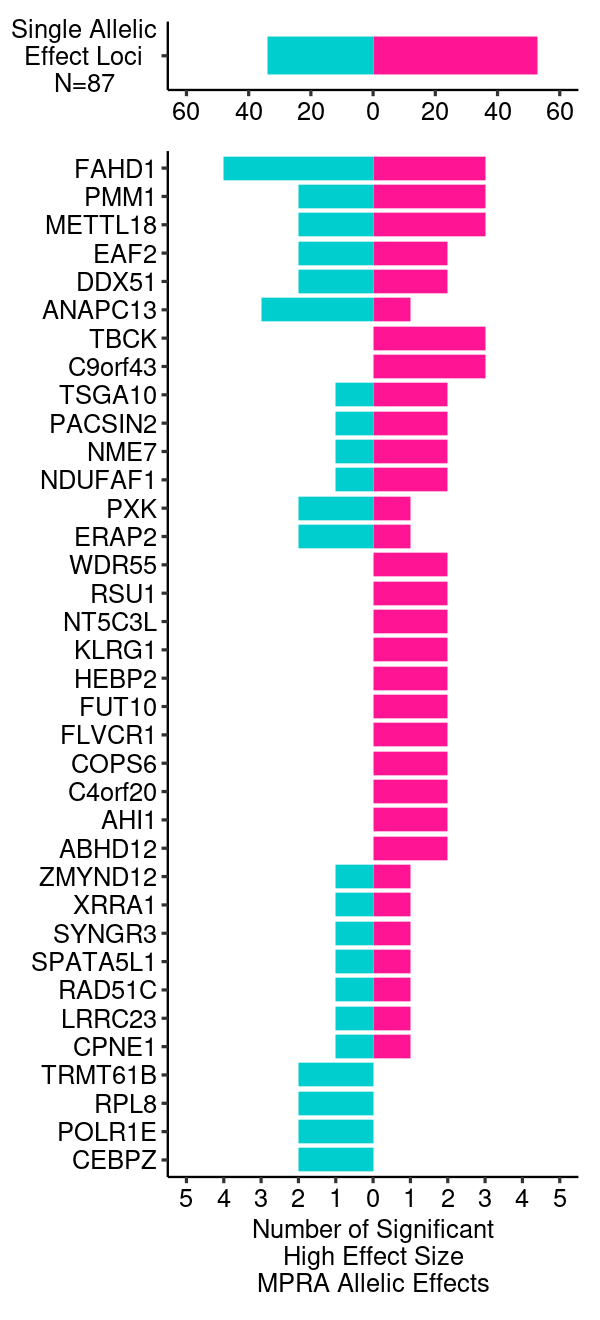

In [48]:
options(repr.plot.width = 5, repr.plot.height = 11)
pE2  + pE1 + plot_layout(design=paste0(c("A\n",rep("B\n",15)),collapse = ""))

`summarise()` regrouping output by 'sign(beta.x) == sign(log2FoldChange_allele)' (override with `.groups` argument)

`summarise()` regrouping output by 'sign(beta.x) == sign(log2FoldChange_allele)' (override with `.groups` argument)

`summarise()` regrouping output by 'sign(beta.x) == sign(log2FoldChange_allele)' (override with `.groups` argument)

`summarise()` regrouping output by 'sign(beta.x) == sign(log2FoldChange_allele)' (override with `.groups` argument)

`summarise()` regrouping output by 'sign(beta.x) == sign(log2FoldChange_allele)' (override with `.groups` argument)

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



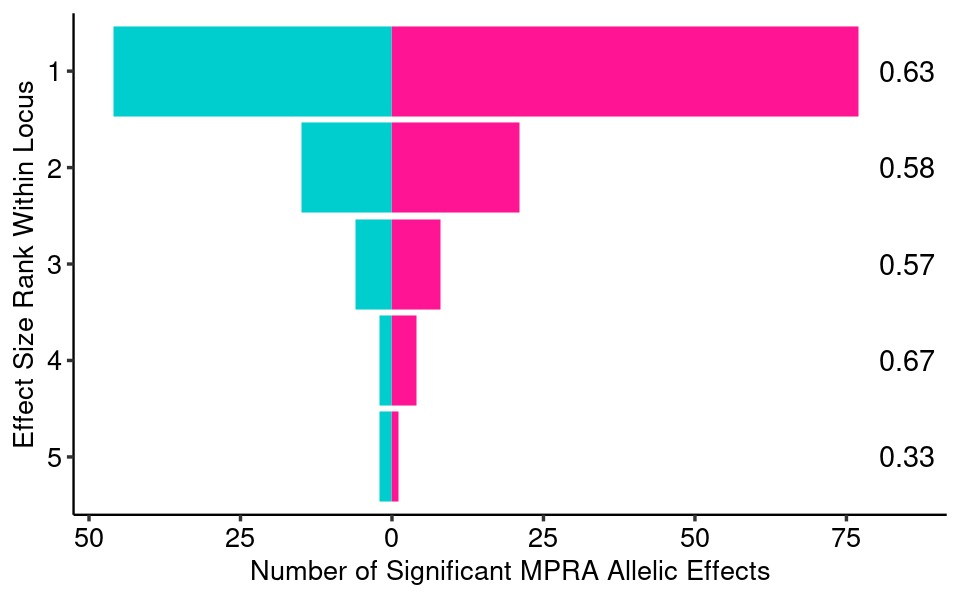

In [49]:
rankProp = data.frame("rank" = numeric(), "concod" = numeric(), "discord" = numeric())

for(i in seq(1,5,1)){
    
    q = mpraStats.eqtl.sep %>% 
        group_by(NAME,hit) %>% 
        mutate(r = rank(abs(log2FoldChange_allele))) %>%
        filter(r == i) %>%
        group_by(sign(beta.x) == sign(log2FoldChange_allele), hit) %>% 
        summarize(n = n()) %>%
        filter(hit == "hit") 
    
    toAdd = data.frame("rank" = i, "concord" = q[2,3], "discord" = q[1,3])
    rankProp = rbind(rankProp, toAdd)
    
}

names(rankProp) = c("rank","concord","discord")

options(repr.plot.width =8, repr.plot.height = 5)
ggplot(rankProp, aes(group = 1,
                     y = reorder(factor(rank),concord*1.1+discord),
                     yend = reorder(factor(rank),concord*1.1+discord))) +
    geom_segment(aes(x = 0, xend = concord), color = "deeppink", size = 19) +
    geom_segment(aes(x = 0, xend = -discord), color = "cyan3", size = 19) + 
    geom_text(aes(x = 85, label = as.character(round(concord/(concord+discord), digits = 2))), size = 6) +
    theme_pubr( base_size = 16)  +
    xlim(c(-60,90)) +
    scale_x_continuous(breaks = c(-50,-25,0,25,50,75), labels = c(50,25,0,25,50,75)) +
    xlab("Number of Significant MPRA Allelic Effects") +
    ylab("Effect Size Rank Within Locus")

## FRASER POOLED caQTLs

In [50]:
`%notin%` = Negate(`%in%`)

read_caqtl = function(file){
    data = data.frame()
    for(i in excel_sheets(file)){
        p = read_excel(path=file, sheet=i)
        p$pop =i
        data = rbind(data,p)
    }
    return(data)
}

In [51]:
computeOddsRatios = function(labels, categories){
    
    oddsRatios = data.frame("label" = as.character(),
                        "or" = numeric(),
                        "lower" = numeric(),
                        "upper" = numeric(),
                        "midp.exact" = numeric(),
                        "fisher.exact" = numeric(),
                        "chi.square" = numeric(), stringsAsFactors = F)
    
    uniqCategories = unique(categories[!is.na(categories)])
    
    for(categ in uniqCategories){
        
        idx = which(categories == categ | is.na(categories))
        
        testTable = table(labels[idx], is.na(categories[idx])) + 1
        testOddsRatio = suppressWarnings(oddsratio(testTable, correction = T))

        estimates = testOddsRatio$measure[2,]
        pvals = testOddsRatio$p.value[2,]

        newRow = data.frame("label" = as.character(categ),
                            "or" = estimates[1],
                            "lower" = estimates[2],
                            "upper" = estimates[3],
                            "midp.exact" = pvals[1],
                            "fisher.exact" = pvals[2],
                            "chi.square" = pvals[3], stringsAsFactors = F)

        oddsRatios = rbind(oddsRatios, newRow)
        
    }
    
    oddsRatios$fisher.exact.bh = p.adjust(oddsRatios$fisher.exact, method = "BH")
    return(oddsRatios)
}

In [52]:
fraser.caqtl.all = data.frame("Chr" = character(),
                              "position" = numeric(),
                              "ALTallele" = character(),
                              "REFallele" = character(),
                              "higherBindingAllele" = character(),
                              "pvalue" = numeric())

pops = c("CEU","IBS","FIN","TSI","ASW","LWK","GWD","CHB","ESN","YRI")
for(pop in pops){
    df = read_xlsx("annotation/Tehranchi_caQTL.xlsx", pop)
    df$pop = pop
    fraser.caqtl.all = rbind(fraser.caqtl.all,df)
}

fraser.caqtl.all$Chr = paste0("chr",as.character(fraser.caqtl.all$Chr))

In [53]:
fraser.caqtl.popCount = fraser.caqtl.all %>% 
                            group_by(Chr,position) %>% 
                            summarize(count = n())

p = merge(mpraStats.tmp, 
          fraser.caqtl.popCount, 
          by.x = c("chrom","pos"), by.y = c("Chr","position"),all.x =T)

p$countCut = cut(p$count, breaks = c(0,3.5,6.5,10))

hitList = ifelse(p$padj_allele <5e-2 & p$padj_expr < 5e-2, "hit","nonhit")
popCount.OR = computeOddsRatios(hitList, p$count)

caaQtlAll.sharing = ggplot(data = subset(popCount.OR, label != "None")) + 
                        geom_errorbarh(aes(y = factor(label, levels = seq(1,10,1)), xmin = log2(lower), xmax = log2(upper)),
                                        stat = "identity") +
                        geom_point(aes(y = factor(label, levels = seq(1,10,1)), x = log2(or)),
                                        stat = "identity") +
                        geom_vline(aes(xintercept = 0), color = "red") + theme_pubr(base_size = 15) + 
                        theme(axis.title.y = element_blank(), legend.title = element_blank()) + xlab("log2(odds ratio)") + ylab("") +
                        scale_color_manual(values = c("red","black"))

popCount.OR.group = computeOddsRatios(hitList, p$countCut)
popCount.OR.group$label = c("1-3","4-6","7-10")
caaQtlAll.sharingGroup = ggplot(data = subset(popCount.OR.group, label != "None")) + 
                            geom_errorbar(aes(x = label, ymin = log2(lower), ymax = log2(upper)),
                                            stat = "identity", width = 0.5,size=1.5) +
                            geom_point(aes(x = label, y = log2(or)),
                                            stat = "identity", size = 5) +
                            geom_hline(aes(yintercept = 0), color = "black") + theme_pubr(base_size = 20) + 
                            theme(legend.title = element_blank()) + ylab("log2(odds ratio)") +
                            scale_color_manual(values = c("red","black"))

`summarise()` regrouping output by 'Chr' (override with `.groups` argument)



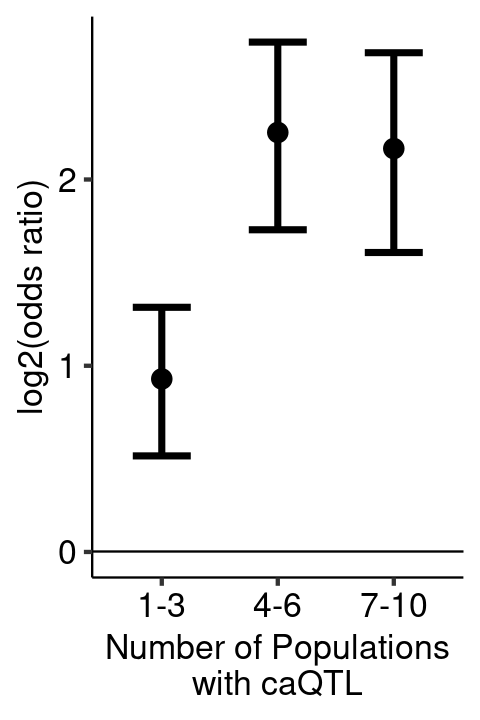

In [54]:
options(repr.plot.width= 4, repr.plot.height = 6)
caaQtlAll.sharingGroup + xlab("Number of Populations\nwith caQTL")

In [55]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/libopenblas-r0.3.3.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] readxl_1.3.1      epitools_0.5-10.1 ggridges_0.5.2    ggrepel_0.8.2    
 [5] rmutil_1.1.5      patchwork_1.1.0   ggpubr_0.4.0      GGally_2.0.0     
 [9] exact2x2_1.6.5    exactci_1.3-3     ssanv_1.1         pROC_1.16.2      
[13] data.table_1.13.2 forcats_0.5.0     stringr_1.4.0     dplyr_1.0.2      
[17] purrr_0.3.4       read